### Neural Network Style Transfer  

This notebook is just a simple try on this topic, following the instructions on [TensorFlow Web](https://www.tensorflow.org/tutorials/generative/style_transfer)  

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import PIL.Image
import time
import functools

In [2]:
def tensor_to_image(tensor):
    tensor = tensor*255                        # scale back to 256 colors
    tensor = np.array(tensor, dtype=np.uint8)  # store using unsigned 8 bit int
    if np.ndim(tensor) > 3:                    # if the tensor is greater than 3 dimensions
        assert tensor.shape[0] == 1            # make sure that the first dim is 1
        tensor = tensor[0]                     # limit max dim to 3
    return PIL.Image.fromarray(tensor)         # return the converted image

In [3]:
# download images
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [4]:
def load_img(path_to_img):
    max_dim = 512                                        # set max pixels dim
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)         # first detect img type, then decode it to RGB, default output dtype is uint8
    img = tf.image.convert_image_dtype(img, tf.float32)  # convert from uint8 to float32
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)      # get img shape, except for last dim (3 for RGB, no need be used in scaling)
    long_dim = max(shape)
    scale = max_dim / long_dim                           # calc scaling num
    new_shape = tf.cast(shape * scale, tf.int32)         # convert shape from float32 to int32 (limit max dim to 512)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img                                           # returned image is in range [0..1]

In [5]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0) # remove dimension of size 1 from the shape of a tensor
    plt.imshow(image)
    if title:
        plt.title(title)

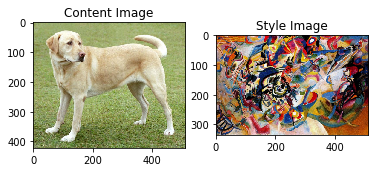

In [6]:
content_image = load_img(content_path)
style_image = load_img(style_path)
plt.subplot(1, 2, 1)
imshow(content_image, "Content Image")
plt.subplot(1, 2, 2)
imshow(style_image, "Style Image")

In [7]:
content_image.shape, style_image.shape

(TensorShape([1, 422, 512, 3]), TensorShape([1, 336, 512, 3]))

### Load VGG19 and Try It!  
[Paper Link](https://arxiv.org/abs/1409.1556)

In [8]:
# load VGG19 and test it!
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)      # scale to [0..255]
x = tf.image.resize(x, (244, 244))
vgg = tf.keras.applications.VGG19(include_top=True, weights="imagenet")  # include_top: include 3 fully-connected layers (for classification) at the top
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [9]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Labrador_retriever', 0.48865917),
 ('golden_retriever', 0.27793348),
 ('kuvasz', 0.030277295),
 ('Chesapeake_Bay_retriever', 0.022466984),
 ('Saluki', 0.021499423)]

VGG19 is tested to be correct now

### Now Select Intemediate Layers

In [10]:
# load the model without classification layers
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
for layer in vgg.layers:
    print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [11]:
content_layers = ["block5_conv2"]   # choose deeper layers for content extraction
style_layers = ["block1_conv1",     # choose upper layers for style extraction
                "block2_conv1",
                "block3_conv1",
                "block4_conv1",
                "block5_conv1"]
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

### Build Model

In [12]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights="imagenet")
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [13]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape:", output.numpy().shape)
    print("  min:", output.numpy().min())
    print("  max:", output.numpy().max())
    print("  mean:", output.numpy().mean())
    print()

block1_conv1
  shape: (1, 336, 512, 64)
  min: 0.0
  max: 835.5256
  mean: 33.97525

block2_conv1
  shape: (1, 168, 256, 128)
  min: 0.0
  max: 4625.8857
  mean: 199.82687

block3_conv1
  shape: (1, 84, 128, 256)
  min: 0.0
  max: 8789.239
  mean: 230.78099

block4_conv1
  shape: (1, 42, 64, 512)
  min: 0.0
  max: 21566.135
  mean: 791.24005

block5_conv1
  shape: (1, 21, 32, 512)
  min: 0.0
  max: 3189.2542
  mean: 59.179478



**Style Calculation:**  
$$G^l_{cd}=\frac{\sum_{ij}F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

In [14]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum("bijc,bijd->bcd", input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return (result / num_locations) # return average of sum

In [15]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False # freeze the weights of layers
        
    def call(self, inputs):
        # inputs should be in [0..1]
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])  # get outputs
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]                        # calculate style
        content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}
        return {"content":content_dict, "style":style_dict}

In [16]:
# test the class functions
extractor = StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))
style_results = results["style"]
print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.005522845
    max:  28014.564
    mean:  263.79025

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.465
    mean:  9100.949

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.44
    mean:  7660.976

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320501.0
    mean:  134288.84

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.34
    mean:  1487.0381

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8796
    mean:  13.764149



In [17]:
style_targets = extractor(style_image)["style"]
content_targets = extractor(content_image)["content"]
image = tf.Variable(content_image) # define an image for training

In [18]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [19]:
# create optimizer
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [20]:
style_weight = 1e-2
content_weight = 1e4

In [21]:
# calculate loss
def style_content_loss(outputs):
    style_outputs = outputs["style"]
    content_outputs = outputs["content"]
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers # calculate mean square error
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers # calculate mean square error
    loss = style_loss + content_loss
    return loss

In [22]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

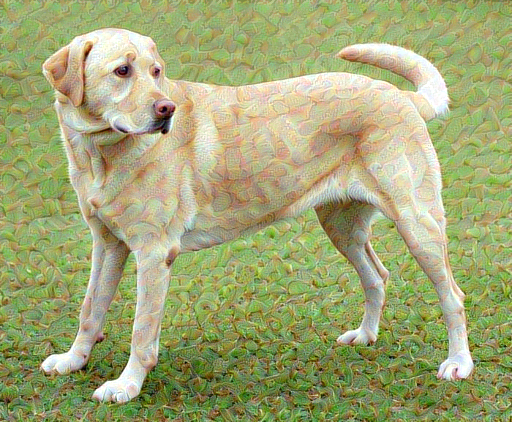

In [23]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

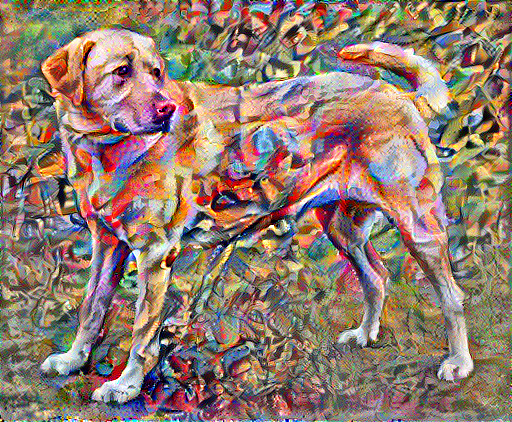

Train Step: 1000
Total Time: 52.6


In [24]:
import time
from IPython.display import clear_output
start = time.time()
epochs = 10
steps_per_epoch = 100
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end="")
    clear_output(wait=True)
    display(tensor_to_image(image))
    print("Train Step: {}".format(step))
end = time.time()
print("Total Time: {:.1f}".format(end - start))

### Total Variation Loss

In [25]:
def high_pass_x_y(image):
    x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
    y_var = image[:, 1:, :, :] - image[:, :-1, :, :]
    return x_var, y_var

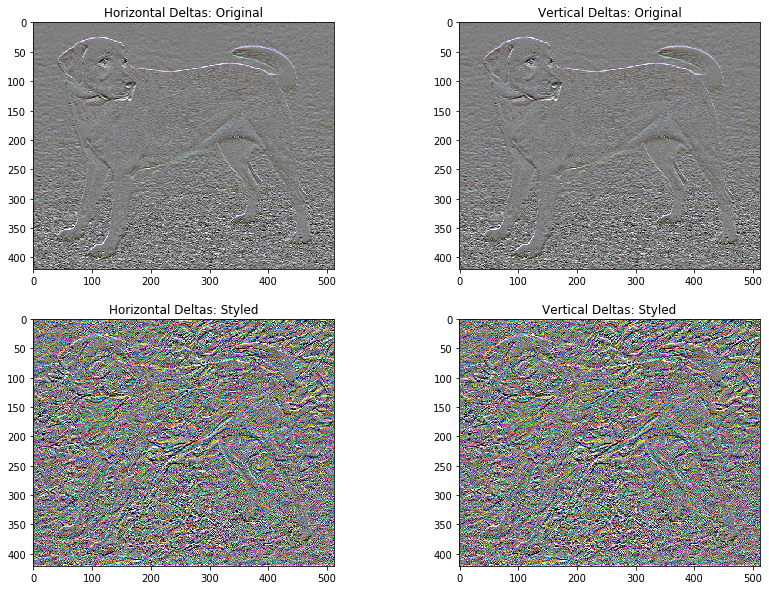

In [26]:
x_deltas, y_deltas = high_pass_x_y(content_image)
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")
plt.subplot(2, 2, 2)
imshow(clip_0_1(2*y_deltas+0.5), "Vertical Deltas: Original")
x_deltas, y_deltas = high_pass_x_y(image)
plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")
plt.subplot(2, 2, 4)
imshow(clip_0_1(2*y_deltas+0.5), "Vertical Deltas: Styled")

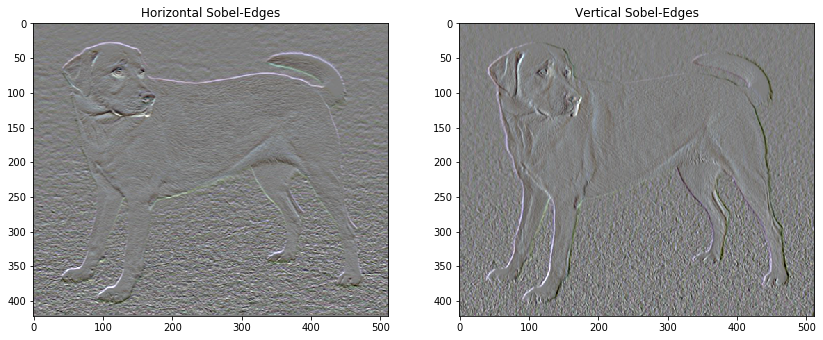

In [27]:
plt.figure(figsize=(14, 10))
sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0]/4 + 0.5), "Horizontal Sobel-Edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1]/4 + 0.5), "Vertical Sobel-Edges")

In [28]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [29]:
total_variation_loss(image).numpy()

149229.89

In [30]:
tf.image.total_variation(image).numpy() # tf also has a standard implementation

array([149229.89], dtype=float32)

In [31]:
total_variation_weight = 30
# enhance the training function
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight * total_variation_loss(image)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [32]:
image = tf.Variable(content_image) # reset image for training

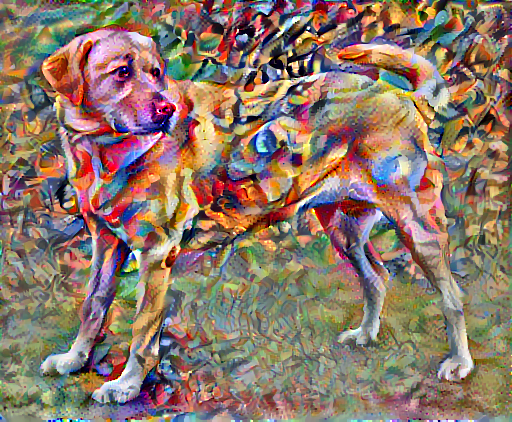

Train Step: 1000
Total Time: 54.6


In [33]:
start = time.time()
epochs = 10
steps_per_epoch = 100
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end="")
    clear_output(wait=True)
    display(tensor_to_image(image))
    print("Train Step: {}".format(step))
end = time.time()
print("Total Time: {:.1f}".format(end - start))

### End of copying code. Time for Explorations!